#1. Import modules

In [4]:
from torchvision import transforms
from torchvision import datasets
import numpy as np
import PIL
import torch
import torch.nn as nn
import torchvision.datasets as dset

import torch.utils.data
import torchvision


#2. Set main parameters 

In [5]:
batch_size = 32
frame_size = (224, 224)

# choose torch device
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'


#2.1. Choose architecture and model checkpoint

In [6]:
import custom_resnets
import custom_densenets

# set number of OA grades and dataset directory
dataset_dir = 'dataset/test'
n_classes = 5

# choose an architecture
cnn_model = custom_densenets.se_densenet121_model(n_classes)
# cnn_model = custom_resnets.se_resnet18_model(n_classes)

# example loading existing models
cnn_model.load_state_dict(torch.load('models/densenet_train/65.625.ckpt', map_location=torch.device(device)))

#3. Prepare dataset

In [7]:
from torch.utils.data.sampler import SequentialSampler

transforms_to_test = transforms.Compose([
              transforms.Resize(frame_size), 
              transforms.ToTensor(),
              transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ])

test_dataset = datasets.ImageFolder(dataset_dir, transform=transforms_to_test)
test_idx = list(range(len(test_dataset.imgs)))
test_sampler = SequentialSampler(test_idx)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/test'

#4. Check accuracy

In [ ]:
import utils

# prepare model to cpu/gpu calc.
if torch.cuda.is_available():
    cnn_model.type(torch.cuda.FloatTensor)
else:
    cnn_model.type(torch.FloatTensor)
    
# model information
total_params = sum(p.numel() for p in cnn_model.parameters())
total_trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print("parameters number: ", total_params)
print("trainable parameters number: ", total_trainable_params)

predictions = []
raw_predictions = []
ground_truth = []

with torch.no_grad():
  print("compute accuracy...")
  test_accuracy, predictions, ground_truth, raw_predictions = utils.compute_accuracy(cnn_model, test_loader)
  print("test accuracy:", test_accuracy)


parameters number:  10008263
trainable parameters number:  10008263
compute accuracy...
test accuracy: 67.69323671497584


#5. Calculate metrics

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

def performance_matrix(true, pred):
    precision = metrics.precision_score(true,pred,average='weighted')
    recall = metrics.recall_score(true,pred,average='weighted') # average='weighted'
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='weighted')
    print('Mean \n  precision: {} \n  recall: {}, \n  accuracy: {}, \n  f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

performance_matrix(ground_truth, predictions)


from tabulate import tabulate
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(ground_truth, predictions)

print('\n')
print('rows is precision, recall, fscore and support:')
print(tabulate([precision, recall, fscore, support], headers=['0' , '1' , '2' , '3', '4'], tablefmt='orgtbl'))

print('\n')
print('per-class accuracy:')
cm = confusion_matrix(ground_truth, predictions)
cm = cm.astype('float')*100 / cm.sum(axis=1)[:, np.newaxis]
print(tabulate([cm.diagonal()], headers=['0' , '1' , '2' , '3', '4'], tablefmt='orgtbl'))


Mean 
  precision: 67.93382315038046 
  recall: 67.69323671497585, 
  accuracy: 67.69323671497585, 
  f1_score: 66.77374197104082


rows is precision, recall, fscore and support:
|          0 |          1 |          2 |          3 |         4 |
|------------+------------+------------+------------+-----------|
|   0.699755 |   0.336996 |   0.769231 |   0.855072 |  0.854167 |
|   0.893584 |   0.310811 |   0.536913 |   0.793722 |  0.803922 |
|   0.78488  |   0.323374 |   0.632411 |   0.823256 |  0.828283 |
| 639        | 296        | 447        | 223        | 51        |


per-class accuracy:
|       0 |       1 |       2 |       3 |       4 |
|---------+---------+---------+---------+---------|
| 89.3584 | 31.0811 | 53.6913 | 79.3722 | 80.3922 |


<Axes: title={'center': 'Confusion matrix, with normalization'}, xlabel='Predicted label', ylabel='True label'>

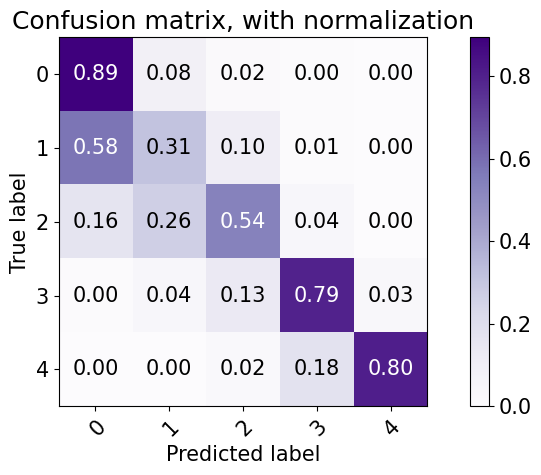

In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


plot_confusion_matrix(ground_truth, predictions, classes=["0", "1", "2", "3", "4"],normalize= True, title='Confusion matrix, with normalization')
